In [1]:
from pathlib import Path
from tqdm import tqdm
import SimpleITK as sitk
import numpy as np
import pandas as pd
import trimesh
import pyvista as pv
import matplotlib.pyplot as plt

from dataloaders import VIA11_Corrected_CS_Loader

from PIL import Image, ImageDraw, ImageFont
from spam import SPAM

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
mesh_paths = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/shape_features/meshes/n30d21/')

In [ ]:

for f in mesh_paths.iterdir():
    if f.is_dir():
        meshes = [x for x in f.glob('**/*.ply')]
        spam_path = f/'imgs/spam'
        spam_path.mkdir(parents=True, exist_ok=True)
        for meshp in tqdm(meshes):
            plotter = pv.Plotter(off_screen=True, line_smoothing=True, polygon_smoothing=True)
            mesh = pv.read(str(meshp))
            actor = plotter.add_mesh(mesh, color='white', smooth_shading=True)
            plt.imshow(plotter.screenshot(transparent_background=True))
            plt.axis('off')
            plt.savefig(spam_path/(meshp.name).replace('.ply', '.png'), bbox_inches='tight', pad_inches=0, dpi=300,
                        transparent=True)
            plt.close()
            plotter.close()

100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


In [3]:
sulci_imgs_path = mesh_paths/'feature_0/imgs/spam'
spam_imgs = [x for x in sulci_imgs_path.glob('**/*.png')]

In [4]:
x_coords = np.linspace(0, 3000, 20)
x_coords = x_coords - x_coords[0]+ 10

resize_scale = 0.5
padd = 50
background = Image.new('RGBA', (5000, 2000), (255, 255, 255, 255))
draw = ImageDraw.Draw(background)
font = ImageFont.truetype("/mrhome/vladyslavz/Downloads/Lato/Lato-Regular.ttf",
                          48)
spam_loc = 1200

for i,s in enumerate(spam_imgs):
    spam_img = Image.open(s, 'r')
    bbox = spam_img.getbbox()
    spam_img = spam_img.crop(bbox)
    spam_img = spam_img.resize((int(spam_img.size[0]*resize_scale),
                                int(spam_img.size[1]*resize_scale)))
    background.paste(spam_img, (int(x_coords[i]) + padd*i, spam_loc), spam_img)
    
    isomap_val = '{:.2f}'.format(float(s.name.split('_')[1][:-4]))
    spam_img_h, spam_img_w = spam_img.size
    draw.text((x_coords[i]+spam_img_w/2-180 + padd*i,
               spam_loc + 175+350),
              str(isomap_val),(0,0,0, 255),
              font=font)

background.save('out.png')

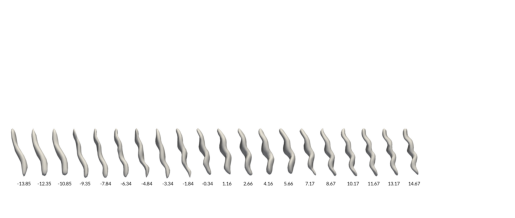

In [5]:
# plot
background_img = plt.imread('out.png')
plt.imshow(background_img)
# plt.axes().set_aspect('equal')
plt.axis('off')
plt.show()

In [6]:
ismap, sdm_transformed = pd.read_pickle('./meshes/n30d21/spam_isomap_meta.pkl')
sulci_reg_keys = np.load('/mrhome/vladyslavz/git/central-sulcus-analysis/sulci_reg_keys.npy')

In [7]:
subj_isomap_df = pd.DataFrame([(x[16:17], x[21:],
                                *sdm_transformed[i]) for i, x in enumerate(sulci_reg_keys[0])],
                              columns=['side', 'subject',
                                       *['isomap_'+str(i) for i in range(21)]])
subj_isomap_df

,side,subject,isomap_0,isomap_1,isomap_2,isomap_3,isomap_4,isomap_5,isomap_6,isomap_7,...,isomap_11,isomap_12,isomap_13,isomap_14,isomap_15,isomap_16,isomap_17,isomap_18,isomap_19,isomap_20
0,l,sub-via003,-9.015415,-1.582360,-0.203460,-0.057135,-5.037800,0.021345,0.251409,-1.209724,...,-1.707123,4.472974,0.415924,-4.982517,-0.851752,0.665141,1.107250,-0.446265,0.721467,2.678067
1,r,_sub-via003,-12.235952,-2.145134,-0.437542,-3.301615,-4.423483,2.225364,0.531153,2.671329,...,-1.776145,-1.693887,1.131870,0.311320,0.817305,-2.610291,0.833522,0.818733,-0.771177,-0.169198
2,l,sub-via004,-0.725658,-3.705586,-1.356401,0.305262,-1.966309,-0.190265,0.725702,-3.374369,...,1.816090,-1.145743,0.664996,-0.016519,1.414551,1.226250,2.098263,-0.405085,-1.375224,2.201093
3,r,_sub-via004,-5.638409,-2.823794,-1.346390,2.821605,-3.895006,-2.303165,1.576009,-1.264243,...,-0.019042,-0.187362,2.521002,-0.229148,-1.789276,-0.936420,1.460735,0.607285,-0.639516,2.847785
4,l,sub-via005,-0.112486,6.179390,-1.887581,1.021943,-0.530843,-1.143114,-2.025661,-3.550406,...,3.213703,0.191927,0.892932,-2.599191,-3.834928,1.350487,-0.417816,-1.811961,-1.647358,2.869249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,r,_sub-via515,2.198120,-1.133721,2.300317,-2.371620,-2.142389,-2.246385,0.158933,0.231524,...,1.649328,1.750282,-0.208848,0.123805,-0.867794,0.739943,0.097622,0.639845,-0.398174,1.309867
568,l,sub-via517,4.161708,-1.112057,-2.485338,0.125550,-4.836034,-0.479852,-1.881067,2.565126,...,-0.186925,-1.307839,-0.665539,-2.022199,0.338169,-1.318625,2.666937,0.255519,0.056972,1.325897
569,r,_sub-via517,3.489077,-1.932911,3.123544,-0.999256,-0.808055,0.510284,2.471100,0.615300,...,4.281978,1.934458,-0.450342,-0.700317,0.094026,0.621250,-2.248366,0.564111,2.840954,1.330711
570,l,sub-via522,9.104972,-0.685331,2.531892,1.634562,-3.918253,-0.856038,-1.222695,2.734567,...,0.639669,-1.756633,3.488137,-0.224831,3.454104,2.327441,3.579755,-3.976877,-3.411857,0.048054


In [9]:
asmp = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/shape_features/meshes/all_subj_meshes_reg/imgs')

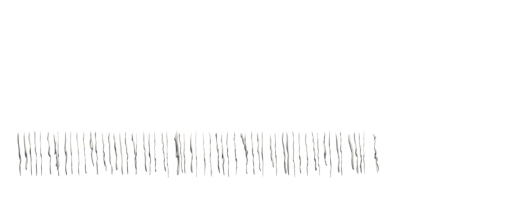

In [27]:
TOTAL_IMGS = 60
isomap_dim = 'isomap_11'
x_coords = np.linspace(0, 3000, TOTAL_IMGS)
x_coords = x_coords - x_coords[0]+ 10

background = Image.new('RGBA', (5000, 2000), (255, 255, 255, 255))
draw = ImageDraw.Draw(background)
font = ImageFont.truetype("/mrhome/vladyslavz/Downloads/Lato/Lato-Regular.ttf",
                          48)
spam_loc = 1200

resize_scale = 0.5
padd = 1

sorted_indexes_array = subj_isomap_df.sort_values(by=isomap_dim, ascending=True).index.values
spaced_idxs = np.round(np.linspace(0, len(sorted_indexes_array) - 1, TOTAL_IMGS)).astype(int)

for idx, i in enumerate(spaced_idxs):
    # print(sorted_indexes_array[i])
    subject = subj_isomap_df.iloc[sorted_indexes_array[i]].subject.strip('_')
    side = subj_isomap_df.iloc[sorted_indexes_array[i]].side
    side = 'left' if side == 'l' else 'right'
    img = Image.open(asmp/f'{subject}_{side}.png')

    bbox = img.getbbox()
    spam_img = img.crop(bbox)
    spam_img = img.resize((int(spam_img.size[0]*resize_scale),
                                int(spam_img.size[1]*resize_scale)))
    background.paste(spam_img, (int(x_coords[idx]) + padd*i, spam_loc), spam_img)
    # break

background.save('out2.png')
# plot
background_img = plt.imread('out2.png')
plt.imshow(background_img)
# plt.axes().set_aspect('equal')
plt.axis('off')
plt.show()

In [9]:
cs = VIA11_Corrected_CS_Loader(bv_good=True, corrected=True, all_bv=False, preload=False)


In [17]:
spam_sulci = pd.read_pickle('/mrhome/vladyslavz/git/central-sulcus-analysis/shape_features/data/nobackup/spam.pkl') 

In [29]:
spam_mpath = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/shape_features/meshes/all_subj_meshes_reg')
spam_mpaths = spam_mpath.glob('*.ply')

In [52]:
pv.CameraPosition()

TypeError: CameraPosition.__init__() missing 3 required positional arguments: 'position', 'focal_point', and 'viewup'

In [103]:
for meshpp in tqdm(spam_mpaths, total=572):

    plotter = pv.Plotter(off_screen=True, line_smoothing=True, polygon_smoothing=True)
    
    mesh = pv.read(str(meshpp))
    actor = plotter.add_mesh(mesh, color='white', smooth_shading=True)
    plotter.camera.view_angle = 30.0
    # plt.imshow(plotter.screenshot(transparent_background=True))
    # plt.axis('off')
    # plt.savefig(spam_mpath/ ('imgs/' + meshpp.name.replace('.ply', '.png')), bbox_inches='tight', pad_inches=0, dpi=300,
                # transparent=True)
    # plt.close()
    # plotter.close()
    
    break

  0%|          | 0/572 [00:00<?, ?it/s]


In [106]:
plotter.camera_position = [(93., 189., 139.),
                           (36., 132., 82.),
                           (0.0, 0.0, 1.0)]

/mrhome/vladyslavz/anaconda3/envs/css/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


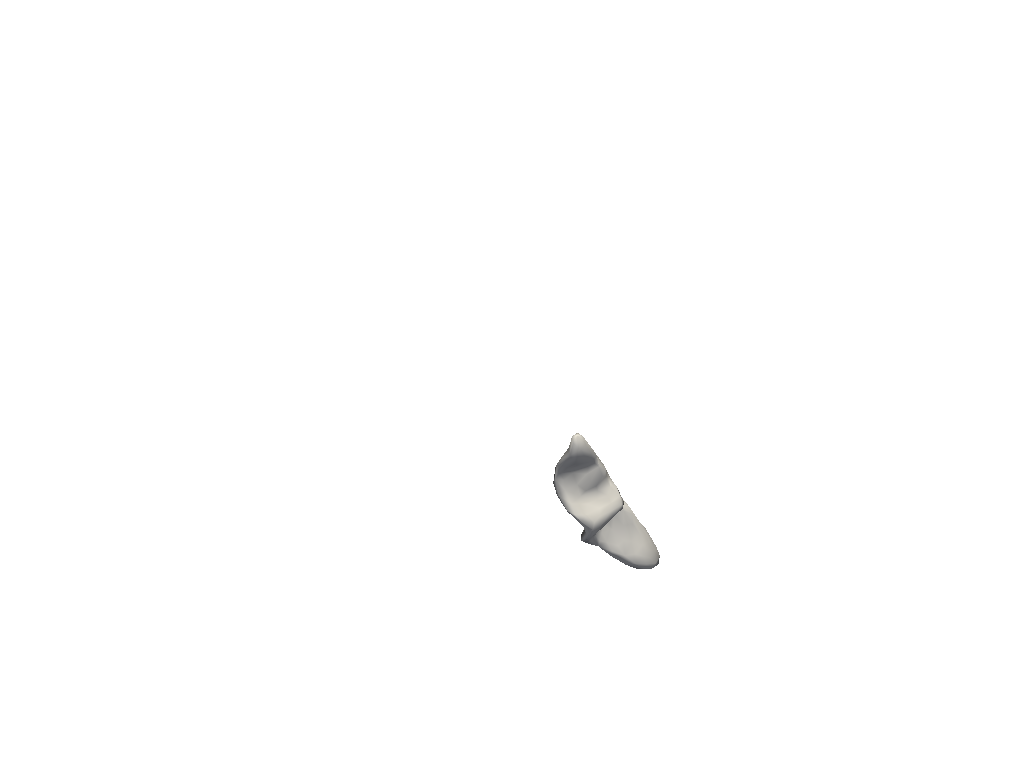

In [107]:
plotter.show()